
Eleventh exercice: Self-calibrated CS-pMR image reconstruction from undersampled non-Cartesian data
==================================================================================================

In this tutorial we will reconstruct an MRI image from radial undersampled kspace measurements. Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.

We use the toy datasets available in pysap, more specifically a 2D brain slice and under-sampled Cartesian acquisition over 32 channels.
We compare zero-order image reconstruction with **self-calibrated** multi-coil Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation. The multicoil data $(y_\ell)_\ell$ is collected across multiple, say $L$, channels. The sensitivity maps $(S_\ell)_\ell$ are automically calibrated from the central portion of k-space (e.g. 5%) for all channels $\ell=1, \ldots, L$.

We remind that the synthesis formulation of the non-Cartesian CS-PMRI problem reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \sum_{\ell=1}^L\|y_\ell - F_\Omega  S_\ell \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \sum_{\ell=1}^L \|y_\ell - F_\Omega  S_\ell x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SelfCalibrationReconstructor
from mri.reconstructors.utils.extract_sensitivity_maps import get_Smaps

import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

/home/ciuciu/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/ciuciu/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


Loading input data
---------------------------

/home/ciuciu/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


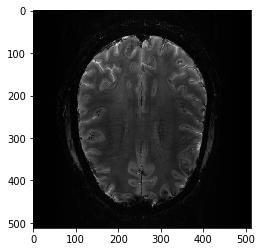

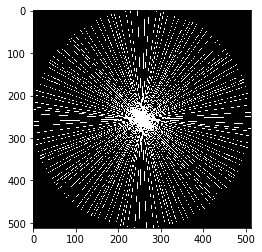

In [2]:
# Loading input data
cartesian_ref_image = get_sample_data('2d-pmri')
image = pysap.Image(data=np.sqrt(np.sum(cartesian_ref_image.data**2, axis=0)))

# Obtain MRI non-Cartesian radial mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))

plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively undersample the k-space using a non cartesian acquisition mask.
We then grid the kspace to get the gridded solution as a baseline.

In [3]:
# Get the kspace observation values for the kspace locations
fourier_op = NonCartesianFFT(
    samples=kspace_loc,
    shape=image.shape,
    n_coils=cartesian_ref_image.shape[0],
    implementation='cpu'
)

kspace_obs = fourier_op.op(cartesian_ref_image)
#fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape,
#                             implementation='cpu', n_coils=cartesian_ref_image.shape[0])
#kspace_obs = fourier_op.op(image.data)


Gridded solution

The Base SSIM is : 0.7282509423603818


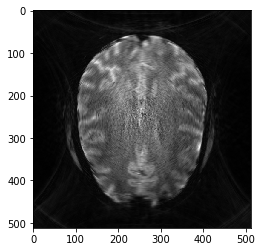

In [4]:
# Gridded solution
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = np.asarray([
    gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs_ch,
                                         tuple(grid2D), 'linear')
    for kspace_obs_ch in kspace_obs
])
image_rec0 = pysap.Image(data=np.sqrt(np.sum(np.abs(grid_soln)**2, axis=0)))

plt.imshow(image_rec0, cmap='gray')
base_ssim = ssim(image_rec0, image)
print('The Base SSIM is : {}'.format(base_ssim))

## Estimate Sensitivity maps (Smaps) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    4.3s finished


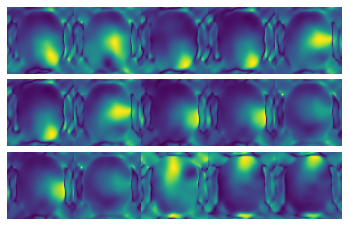

In [6]:
# Obtain SMaps
Smaps, SOS = get_Smaps(
    k_space=kspace_obs,
    img_shape=fourier_op.shape,
    samples=kspace_loc,
    thresh=(0.01, 0.01),    # The cutoff threshold in each kspace direction
                            # between 0 and kspace_max (0.5)
    min_samples=kspace_loc.min(axis=0),
    max_samples=kspace_loc.max(axis=0),
    mode='gridding',
    method='linear',
    n_cpu=-1,
)

h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(Smaps[3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Setup Fourier operators with SENSE
-----------------------------------

In [7]:
# Setup Fourier Operator with SENSE. This would initialize the
# fourier operators in the GPU.
# For this we need to specify the implementation as gpuNUFFT
# and also pass the Smaps calculated above
fourier_implementation = 'cpu'
#fourier_implementation = 'gpuNUFFT'

fourier_op_sense = NonCartesianFFT(
    samples=kspace_loc,
    shape=image.shape,
    n_coils=cartesian_ref_image.shape[0],
    smaps=Smaps,
    implementation=fourier_implementation,
)

FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [27]:
# Setup the operators
linear_op = WaveletN(wavelet_name='sym8', nb_scale=4)
# regularizer_op = SparseThreshold(Identity(), 3 * 1e-9, thresh_type="soft")
regularizer_op = SparseThreshold(Identity(), 1e-8, thresh_type="soft")

In [28]:
# Setup Reconstructor
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op_sense,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Synthesis formulation: FISTA optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [ ]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)

image_rec = pysap.Image(data=x_final)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('FISTA Reconstruction\nSSIM = {}'.format(recon_ssim))
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.9s finished


Lipschitz constant is 377.47294229670257


## POGM reconstruction

 - mu:  6e-07
 - lipschitz constant:  570.4522582982656
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd8c5170ed0> - 4
 - max iterations:  200
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  31.568309169029817  seconds
----------------------------------------


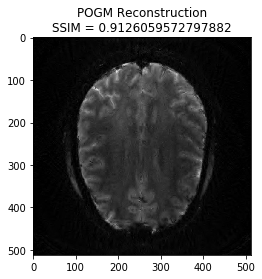

In [9]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=200,
)

image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('POGM Reconstruction\nSSIM = {}'.format(recon_ssim))
plt.show()

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [13]:
#linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

In [14]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 570.452258225419
The lipschitz constraint is satisfied


 - mu:  6e-07
 - lipschitz constant:  570.452258225419
 - tau:  0.003499650305671012
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7fd8c528ba90> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:03:28 Time:  0:03:28


 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  210.95389512297697  seconds
----------------------------------------


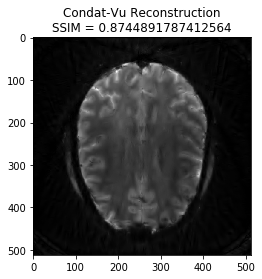

In [15]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()
